In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

import sys
sys.path.insert(0 , "/content/MyDrive/MyDrive/Colab Notebooks/OCR v2")

""" from google.colab import drive
drive.mount('/content/drive') """

Mounted at /content/MyDrive/


" from google.colab import drive\ndrive.mount('/content/drive') "

In [ ]:

from models import ResNet
import matplotlib
matplotlib.use("Agg")
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import string
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def load_dataset(datasetPath):
	# initialize the list of data and labels
	data = []
	labels = []
	# loop over the rows of the ByClass dataset
	for row in open(datasetPath):
		# parse the label and image from the row
		row = row.split(",")
		label = int(row[0])
		image = np.array([int(x) for x in row[1:]], dtype="uint8")
		# images are represented as single channel (grayscale) images
		# that are 28x28=784 pixels -- we need to take this flattened
		# 784-d list of numbers and repshape them into a 28x28 matrix
		image = image.reshape((28, 28))
		# update the list of data and labels
		data.append(image)
		labels.append(label)
        
  # convert the data and labels to NumPy arrays
	data = np.array(data, dtype="float32")
	labels = np.array(labels, dtype="int")
	# return a 2-tuple of the A-Z data and labels
	return (data, labels)


In [ ]:
EPOCHS = 50
#EPOCHS = 50
INIT_LR = 1e-1
#BS = 32
BS = 128

(trainX, trainY) = load_dataset("/content/MyDrive/MyDrive/Colab Notebooks/OCR v2/DATASET/emnist-byclass-train.csv")
(testX, testY) = load_dataset("/content/MyDrive/MyDrive/Colab Notebooks/OCR v2/DATASET/emnist-byclass-test.csv")

In [ ]:
EPOCHS = 50

In [ ]:
def symetrie(n):
    resultat = np.zeros((n,n))
    for i in range(n):
        resultat[n-1-i,i] = 1
    return resultat
import numpy as np  
#len(trainX[10])
#cv2_imshow(cv2.rotate(trainX[22].reshape(28,28).dot(symetrie(28)), cv2.ROTATE_90_COUNTERCLOCKWISE))
symetrie(4)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

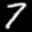

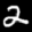

In [ ]:
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32

#trainX = [cv2.resize(image, (32, 32)) for image in trainX]
trainX = [cv2.rotate(cv2.resize(image, (32, 32)).dot(symetrie(32)), cv2.ROTATE_90_COUNTERCLOCKWISE) for image in trainX]
trainX = np.array(trainX, dtype="float32")
cv2_imshow(trainX[10])

#testX = [cv2.resize(image, (32, 32)) for image in testX]
testX = [cv2.rotate(cv2.resize(image, (32, 32)).dot(symetrie(32)), cv2.ROTATE_90_COUNTERCLOCKWISE) for image in testX]
testX = np.array(testX, dtype="float32")
cv2_imshow(testX[10])

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
trainX /= 255.0

testX = np.expand_dims(testX, axis=-1)
testX /= 255.0

In [ ]:
# convert the labels from integers to vectors
le = LabelBinarizer()

trainY = le.fit_transform(trainY)
testY = le.fit_transform(testY)

#number of images of a letter
counts = trainY.sum(axis=0) + testY.sum(axis=0)

classTotals = counts
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
  classWeight[i] = classTotals.max() / classTotals[i]


In [ ]:
""" #ModelCheckpoint callback saves a model at some interval. 
filepath="Checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_freq='epoch', save_best_only=True, mode='max')

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, log_csv] """

' #ModelCheckpoint callback saves a model at some interval. \nfilepath="Checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.\n#Use Mode = max for accuracy and min for loss. \ncheckpoint = ModelCheckpoint(filepath, monitor=\'val_accuracy\', verbose=1, save_freq=\'epoch\', save_best_only=True, mode=\'max\')\n\n#CSVLogger logs epoch, acc, loss, val_acc, val_loss\nlog_csv = CSVLogger(\'my_logs.csv\', separator=\',\', append=False)\n\ncallbacks_list = [checkpoint, log_csv] '

In [ ]:
#ModelCheckpoint callback saves a model at some interval. 
filepath="Checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_freq='epoch', save_best_only=False, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]
#callbacks_list = [checkpoint, log_csv]

In [ ]:
#print(classWeight)
#print(counts)
#!nvidia-smi

In [ ]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")

In [ ]:

# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
  (64, 64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [ ]:
# train the network
print("[INFO] training network...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
  validation_data=(testX, testY),
  steps_per_epoch=len(trainX) // BS,
  epochs=EPOCHS,
  class_weight=classWeight, verbose=1,
  callbacks=callbacks_list)

model.save("handwriting.model", save_format="h5")
model.save('my_model.h5') 

[INFO] training network...
Epoch 1/50
5452/5452 [==============================] - ETA: 0s - loss: 3.3696 - accuracy: 0.6976
Epoch 1: saving model to Checkpoints/weights-improvement-01-0.77.hdf5
5452/5452 [==============================] - 366s 64ms/step - loss: 3.3696 - accuracy: 0.6976 - val_loss: 0.8804 - val_accuracy: 0.7698
Epoch 2/50
5452/5452 [==============================] - ETA: 0s - loss: 2.3477 - accuracy: 0.7763
Epoch 2: saving model to Checkpoints/weights-improvement-02-0.80.hdf5
5452/5452 [==============================] - 348s 64ms/step - loss: 2.3477 - accuracy: 0.7763 - val_loss: 0.7815 - val_accuracy: 0.7955
Epoch 3/50
5452/5452 [==============================] - ETA: 0s - loss: 2.2542 - accuracy: 0.7840
Epoch 3: saving model to Checkpoints/weights-improvement-03-0.78.hdf5
5452/5452 [==============================] - 347s 64ms/step - loss: 2.2542 - accuracy: 0.7840 - val_loss: 0.8072 - val_accuracy: 0.7837
Epoch 4/50
5452/5452 [==============================] - ETA: 

In [ ]:
len(le.classes_)

62

In [ ]:
print("Values stored in history are ... \n", H.history)
plt.plot(H.history['loss'], label='train')
plt.plot(H.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig("plot1.png")


Values stored in history are ... 
 {'loss': [3.2126545906066895, 2.3828978538513184, 2.30488657951355, 2.261653423309326, 2.231156587600708, 2.2164785861968994, 2.2017462253570557, 2.189342498779297, 2.1789567470550537, 2.173949956893921, 2.1669013500213623, 2.158959150314331, 2.150881290435791, 2.1484322547912598, 2.141632556915283, 2.1392462253570557, 2.1335182189941406, 2.1298835277557373, 2.127026081085205, 2.1267244815826416], 'accuracy': [0.7178806662559509, 0.7791242003440857, 0.7846859693527222, 0.7877784967422485, 0.7892631888389587, 0.7902505397796631, 0.7923385500907898, 0.7933345437049866, 0.7941356301307678, 0.7947604060173035, 0.794501006603241, 0.795581579208374, 0.7959641814231873, 0.7966477870941162, 0.7965087890625, 0.7973127365112305, 0.7969129085540771, 0.7983187437057495, 0.7980479001998901, 0.7983173131942749], 'val_loss': [0.8625701665878296, 0.8596137166023254, 0.833027720451355, 0.8284887671470642, 0.8264786005020142, 0.8303713202476501, 0.8139031529426575, 0.8

62
[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.68      0.78      0.72      5778
           1       0.70      0.47      0.56      6330
           2       0.98      0.84      0.91      5869
           3       0.99      0.98      0.99      5969
           4       0.99      0.92      0.95      5619
           5       0.92      0.94      0.93      5190
           6       0.99      0.88      0.93      5705
           7       0.99      0.99      0.99      6139
           8       0.99      0.93      0.96      5633
           9       0.95      0.87      0.91      5686
           A       0.94      0.97      0.95      1062
           B       0.81      0.98      0.89       648
           C       0.83      0.60      0.69      1739
           D       0.65      0.96      0.78       779
           E       0.93      0.99      0.96       851
           F       0.80      0.76      0.78      1440
           G       0.50      0.97      0.66      

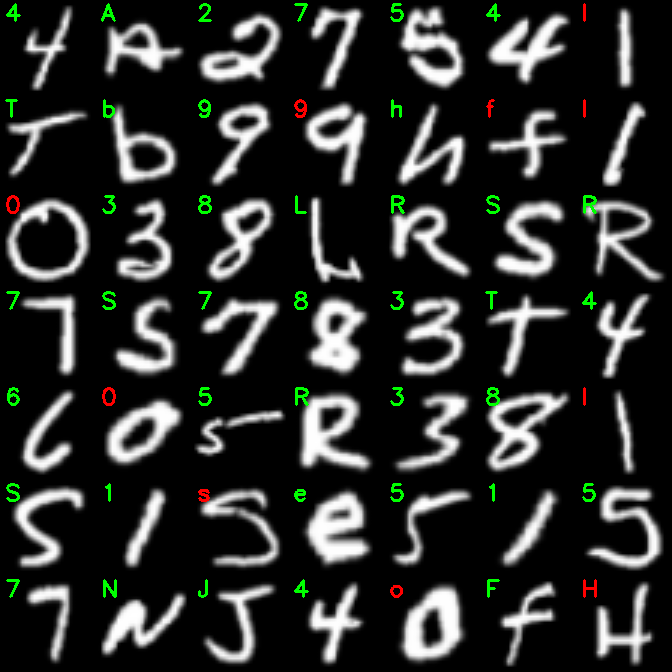

-1

In [ ]:
from google.colab.patches import cv2_imshow
# define the list of label names
labelNames = list(string.digits + string.ascii_uppercase + string.ascii_lowercase )
print(len(labelNames))
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
  predictions.argmax(axis=1), target_names=labelNames))

# save the model to disk
print("[INFO] serializing network...")
model.save("handwriting.model", save_format="h5")
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


# initialize our list of output test images
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
  # classify the character
  probs = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label = labelNames[prediction[0]]
  # extract the image from the test data and initialize the text
  # label color as green (correct)
  image = (testX[i] * 255).astype("uint8")
  color = (0, 255, 0)
  # otherwise, the class label prediction is incorrect
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)
  # merge the channels into one image, resize the image from 32x32
  # to 96x96 so we can better see it and then draw the predicted
  # label on the image
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
    color, 2)
  # add the image to our list of output images
  images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]
# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)

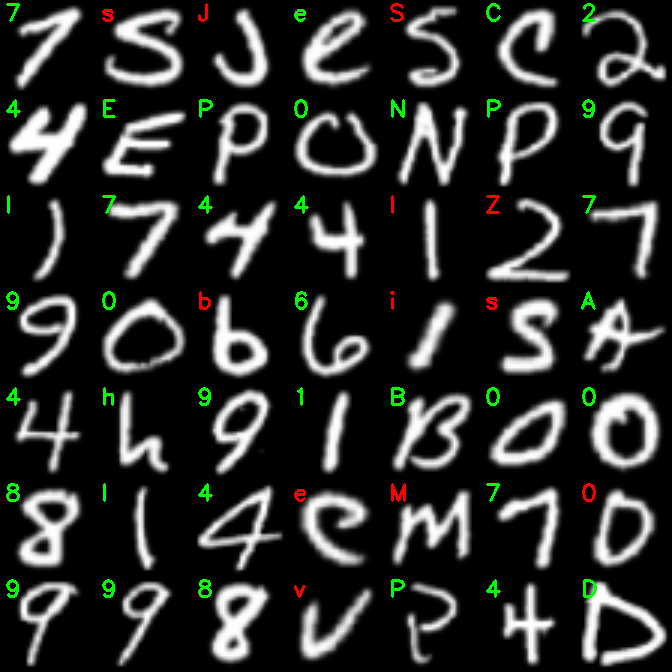

-1

In [ ]:
# initialize our list of output test images
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)
	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]
# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)